# 获取分块矩阵

In [1]:
from datasets import load_dataset

dataset = load_dataset("/data/home/chenpz/git_clone_project/nlpData/p3/anli_can_we_infer_r3")
train_data = dataset['train']

import pickle

# 打开包含数据结构的文件
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/anli_can_we_infer_r3_train.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    embedding_train = pickle.load(f)
import numpy as np
for i in range(len(embedding_train)):
    embedding_train[i]['embedding'] = np.array(embedding_train[i]['embedding'])

train_embedding_matrix = []
for i in range(len(embedding_train)):
    train_embedding_matrix.append(embedding_train[i]['embedding'])

train_embedding_matrix = np.array(train_embedding_matrix)

/data/home/chenpz/.conda/envs/llama_factory/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def split_simliarity_matrix(train_embedding_matrix, split_size):
    block_num, last_matrix_size = np.divmod(train_embedding_matrix.shape[0], split_size)
    split_matrix_list = []
    for i in range(block_num):
        tmp = np.matmul(train_embedding_matrix \
                        ,train_embedding_matrix[ int(i*split_size) :int((i+1)*split_size) ].T)
        split_matrix_list.append(tmp)
    tmp = np.matmul(train_embedding_matrix \
                        ,train_embedding_matrix[ int(block_num*split_size) :].T) 
    split_matrix_list.append(tmp)
    return split_matrix_list


split_size = 35000
split_sim_matrix = split_simliarity_matrix(train_embedding_matrix=train_embedding_matrix,split_size=split_size) 

# 获取 idx:loss pair

In [3]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

x = []
y = []
# 从 JSON 文件读取数据
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/anli_r3_loss_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        x.append(data['id'])
        y.append(data['loss'])


import pickle
import json
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/kcenters_rank_fromFarPoint.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    res = pickle.load(f)


In [4]:
def get_similar(query_id, split_sim_matrix, pop_point_list=[]):
    # 提前创建布尔掩码 
    mask = np.ones(sum(matrix.shape[1] for matrix in split_sim_matrix), dtype=bool)
    mask[pop_point_list] = False
    
    # 拼接向量，并直接使用布尔索引
    sim_vector = np.concatenate(tuple(matrix[query_id] for matrix in split_sim_matrix) , axis=0)
    
    # 使用布尔索引来生成 key 和 value
    # key = np.arange(len(sim_vector))[mask]
    value = sim_vector[mask]
    
    # 创建字典
    # pair = np.mean(value)
    return value



index_dict = [{'id':idx,'ppl':loss} for loss, idx in zip(y,res)]
first_data = sorted(index_dict[:10000], key=lambda x: x['ppl'], reverse=True)
last_data  = sorted(index_dict[-10000:], key=lambda x: x['ppl'], reverse=True)


for data in [index_dict, last_data, first_data]:
    print('ok-')
    for i in range(len(data)):
        vector = get_similar(data[i]['id'], split_sim_matrix, [data[i]['id']])
        data[i]['max_simliarity'] = np.max(vector)
        data[i]['min_simliarity'] = np.min(vector)
        data[i]['Alignment'] = 1 - np.mean(vector)
        data[i]['unsimliar_point'] = np.sum(vector < -0.2)

    

ok-
ok-
ok-


(array([   3.,   15.,   38.,   96.,  200.,  353.,  523.,  720.,  885.,
        1017., 1108., 1020.,  921.,  790.,  579.,  435.,  337.,  264.,
         197.,  179.,  128.,   90.,   46.,   25.,   19.,    6.,    4.,
           0.,    0.,    2.]),
 array([0.83793183, 0.84447331, 0.8510148 , 0.85755629, 0.86409778,
        0.87063927, 0.87718076, 0.88372224, 0.89026373, 0.89680522,
        0.90334671, 0.9098882 , 0.91642969, 0.92297117, 0.92951266,
        0.93605415, 0.94259564, 0.94913713, 0.95567861, 0.9622201 ,
        0.96876159, 0.97530308, 0.98184457, 0.98838606, 0.99492754,
        1.00146903, 1.00801052, 1.01455201, 1.0210935 , 1.02763499,
        1.03417647]),
 <BarContainer object of 30 artists>)

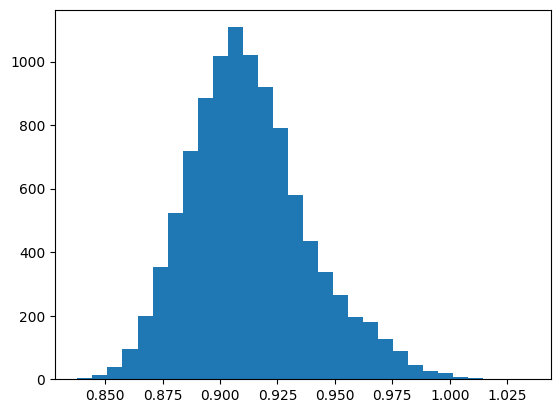

In [8]:
df = pd.DataFrame(data)
plt.hist(df['Alignment'], bins=30)

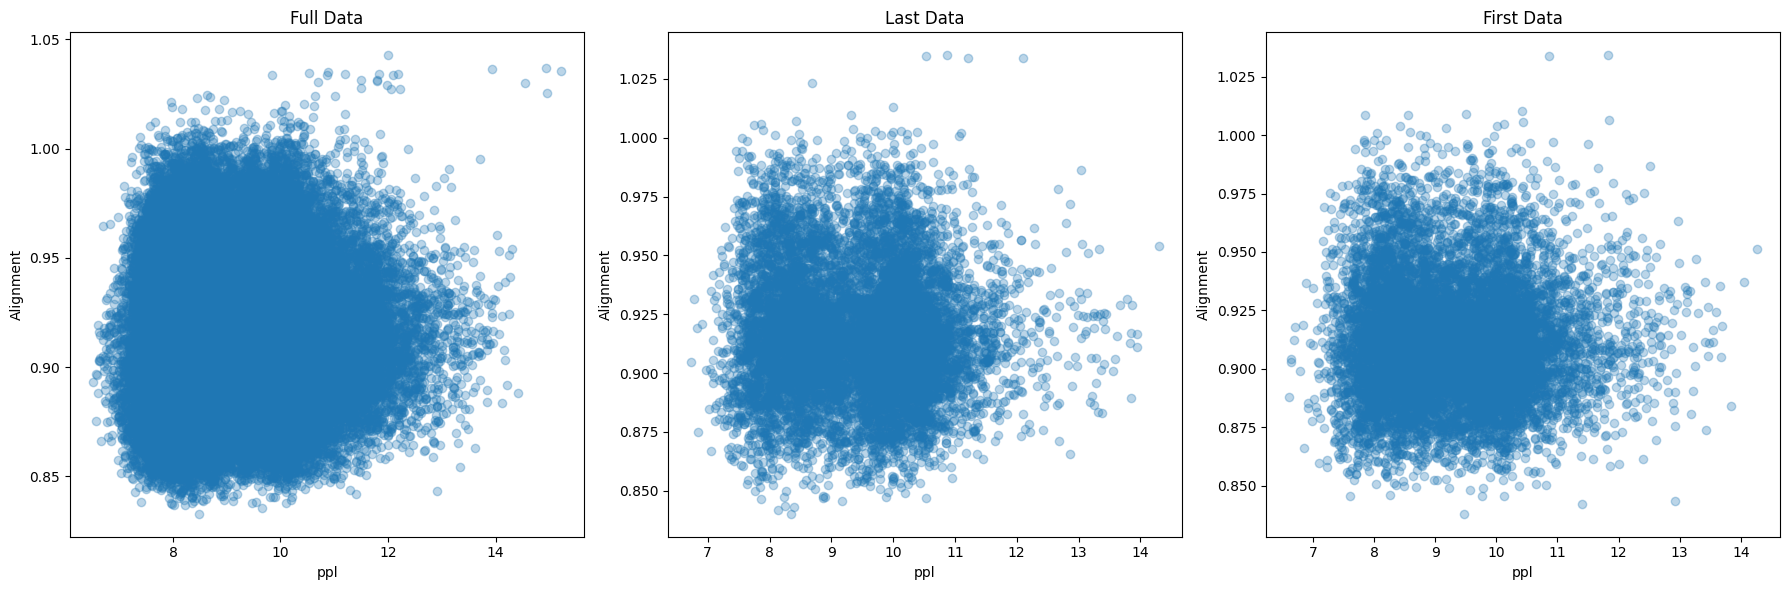

In [5]:
data_list = [index_dict, last_data, first_data]
titles = ['Full Data', 'Last Data', 'First Data']

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for ax, data, title in zip(axs, data_list, titles):
    df = pd.DataFrame(data)
    x_key = 'ppl'
    y_key = 'Alignment'
    ax.scatter(df[x_key], df[y_key], alpha=0.3)
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.set_title(title)

# Adjust layout
plt.tight_layout()
plt.show()

